# Проект [SF] Car classification

## Goal

Цель - классифицировать автомобили по фотографии.

Соревнование kaggle - https://www.kaggle.com/c/sf-dl-car-classification

## Library import

In [63]:
import csv
import glob
import os
import pickle
import shutil
import subprocess
import sys
import tarfile
import zipfile
from datetime import datetime

# import efficientnet.tfkeras as efn
import keras
import matplotlib.pyplot as plt
# Commented out IPython magic to ensure Python compatibility.
import numpy as np
import pandas as pd
import PIL
import scipy.io
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import tensorflow.keras.callbacks as C
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
# from kaggle.api.kaggle_api_extended import KaggleApi
from keras import *
from keras.layers import *
from keras.models import load_model
from pandas.core.indexes import base
from PIL import ImageFilter, ImageOps
from skimage import io
from sklearn.model_selection import train_test_split
#from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.applications import EfficientNetB6, Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.callbacks import (Callback, EarlyStopping,
                                        LearningRateScheduler, ModelCheckpoint)
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Setup

In [64]:
VAL_SPLIT = 0.15  # сколько данных выделяем на тест = 15%
CLASS_NUM = 10  # количество классов в нашей задаче
IMG_CHANNELS = 3   # у RGB 3 канала

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
PYTHONHASHSEED = 0


# kaggle
DATA_PATH_KAGGLE = '../input/'  # path for input data
IMG_PATH_KAGGLE = '../car/'  # path for unpacked data
# colab
DATA_PATH_COLAB = './'
IMG_PATH_COLAB = './car/'

IS_ENV_COLAB = 'google.colab' in sys.modules

if IS_ENV_COLAB:
    DATA_PATH, IMG_PATH = DATA_PATH_COLAB, IMG_PATH_COLAB
else:
    DATA_PATH, IMG_PATH = DATA_PATH_KAGGLE, IMG_PATH_KAGGLE

IMG_TRAIN_PATH = IMG_PATH + 'train'
IMG_MOCK_TRAIN_PATH = IMG_PATH + 'mock_train'

# MOCK_DATA=True - dry run for code testing
MOCK_DATA = True
# MOCK_DATA = False

## Load data

In [65]:
def download_competition_data():
    """
    dowload data in colab from kaggle
    """
    subprocess.run(['mkdir', '-p', '/root/.kaggle'], capture_output=True)
    subprocess.run(['cp', '/content/drive/MyDrive/Colab Notebooks/kaggle/kaggle.json',
                    '/root/.kaggle'], capture_output=True)
    subprocess.run(['kaggle', 'competitions', 'download', '-c',
                    'sf-dl-car-classification'], capture_output=True)


def unzip_data(path_input='.', path_output='.'):
    # unzip data
    if not os.path.exists(path_output):
        os.makedirs(path_output)
    if not all([dir in os.listdir(path_output) for dir in ['train', 'test_upload']]):
        for data_zip in ['train.zip', 'test.zip']:
            with zipfile.ZipFile(f'{path_input}{data_zip}', 'r') as z:
                z.extractall(path_output)


def load_train_test_from_csv(path=DATA_PATH):
    """
    load DataFrames from files (train_df, sample_submission)
    """
    train_df = pd.read_csv(f'{path}train.csv')
    sample_submission = pd.read_csv(f'{path}sample-submission.csv')
    return (train_df, sample_submission)

def decommpress_images():
    """
    load DataFrames from files (train_df, sample_submission)
    """
    if IS_ENV_COLAB:
        # running in colab
        download_competition_data()
    unzip_data(DATA_PATH, IMG_PATH)
    return load_train_test_from_csv(DATA_PATH)


def make_mock_data(n_samples=5):
    """
    Make PATH\mock_train with
    the same tree structure as PATH\train,
    copy n_samples to each directory. 
    """
    src = IMG_PATH + 'train'
    dst = IMG_PATH + 'mock_train'

    for root, dirs, files in os.walk(src):
        new_dir = root.replace(src, dst)
        if not os.path.exists(new_dir):
            os.makedirs(new_dir)
        for file in files[:n_samples]:
            shutil.copy2(f'{root}/{file}', new_dir)


Для работы в Colab необходим подключенный GDrive и файл `content/drive/MyDrive/Colab Notebooks/kaggle/kaggle.json`

In [66]:
decommpress_images()
# load DataFrames
train_df, sample_submission = load_train_test_from_csv()

In [67]:
if MOCK_DATA:
    make_mock_data(n_samples=64)
    sample_submission = sample_submission[:20]
    IMG_TRAIN_PATH = IMG_MOCK_TRAIN_PATH

## EDA

In [68]:
train_df.sample(5)

,Id,Category
99,111114.jpg,0
8450,157246.jpg,5
2882,222821.jpg,1
2177,156050.jpg,1
12856,137541.jpg,8


In [69]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


In [70]:
train_df.Category.value_counts()

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

Распределение классов достаточно равномерное.

In [71]:
def plot_images():
    print('Пример картинок (random sample)')
    plt.figure(figsize=(12, 8))

    random_image = train_df.sample(n=9)
    # random_image_paths = random_image['Id'].values
    # random_image_cat = random_image['Category'].values
    for index, (id, cat) in enumerate(zip(random_image['Id'], random_image['Category'])):
        # for index, path in enumerate(random_image_paths):
        im = PIL.Image.open(f'{IMG_PATH}train/{cat}/{id}')
        plt.subplot(3, 3, index+1)
        plt.imshow(im)
        plt.title('Class: '+str(cat))
        plt.axis('off')
    plt.show()

### Примеры изображений

Пример картинок (random sample)


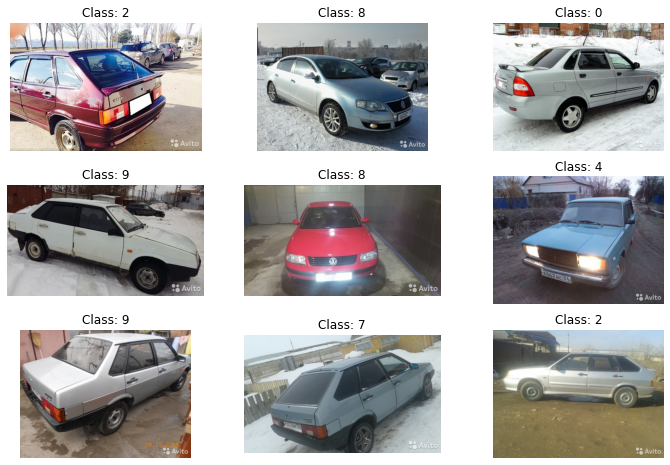

In [72]:
plot_images()

### Разрешения изображений

In [73]:
def plot_im_size(df):
    size = [PIL.Image.open(f'{IMG_PATH}train/{cat}/{id}').size for id,
            cat in zip(df['Id'], df['Category'])]
    s_x = list(map(lambda x: x[0], size))
    s_y = list(map(lambda x: x[1], size))
    plt.scatter(s_x, s_y, s=5)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Image resolutions')
    plt.show()

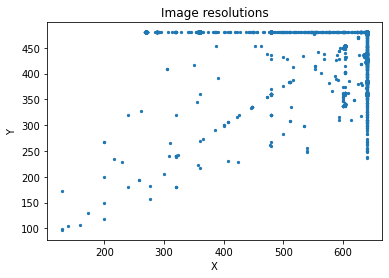

In [74]:
plot_im_size(train_df)

## Подготовка данных

### Аугментация и создание генераторов

In [75]:
def build_generators():
    """
    Build tuple ImageDataGenerators
    for train, validation, submission, tta submission:
    train_generator, val_generator, sub_generator, tta_generator
    """

    # path_train = IMG_PATH+'train/'
    path_train = IMG_TRAIN_PATH
    path_test = IMG_PATH+'test_upload/'

    train_datagen = ImageDataGenerator(  # rescale=1. / 255,
        rotation_range=50,
        shear_range=0.2,
        zoom_range=[0.75, 1.25],
        brightness_range=[0.5, 1.5],
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=False,
        validation_split=VAL_SPLIT)

    test_datagen = ImageDataGenerator()  # rescale=1. / 255)

    tta_datagen = ImageDataGenerator(rescale=1. / 255,
                                     rotation_range=90,
                                     shear_range=0.2,
                                     zoom_range=[0.75, 1.25],
                                     brightness_range=[0.5, 1.5],
                                     width_shift_range=0.1,
                                     height_shift_range=0.1)

    train_generator = train_datagen.flow_from_directory(
        # PATH+'train/',      # директория где расположены папки с картинками
        path_train,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True,
        seed=RANDOM_SEED,
        subset='training')  # set as training data

    val_generator = train_datagen.flow_from_directory(
        # PATH+'train/',
        path_train,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True, seed=RANDOM_SEED,
        subset='validation')  # set as validation data

    sub_generator = test_datagen.flow_from_dataframe(
        dataframe=sample_submission,
        # directory=PATH+'test_upload/',
        directory=path_test,
        x_col="Id",
        y_col=None,
        shuffle=False,
        class_mode=None,
        seed=RANDOM_SEED,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,)

    tta_generator = tta_datagen.flow_from_dataframe(
        dataframe=sample_submission,
        # directory=PATH+'test_upload/',
        directory=path_test,
        x_col="Id",
        y_col=None,
        shuffle=False,
        class_mode=None,
        seed=RANDOM_SEED,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE)

    return (train_generator, val_generator,
            sub_generator, tta_generator)

## Построение моделей

### Xception

Используется модель `tensorflow.keras.applications.Xception` с набором весов imagenet и замененной "головой".

In [76]:
def models_xception_base(input_shape, lr=1e-3):
    '''
    Xception new
    For Xception, call
    tf.keras.applications.xception.preprocess_input 
    on your inputs before passing them to the 
    model.xception.preprocess_input will scale input 
    pixels between -1 and 1.
    '''
    base_model = Xception(weights='imagenet',
                          include_top=False,
                          input_shape=input_shape,
                          pooling='avg')
    # unfreeze_model(base_model, ratio=unfreeze_ratio)

    inputs = keras.Input(shape=input_shape)
    x = tf.cast(inputs, tf.float32)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    # base_model.summary()

    # let's add a fully-connected layer
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    # and a logistic layer -- let's say we have 10 classes
    predictions = Dense(CLASS_NUM, activation='softmax')(x)

    # this is the model we will train
    model = Model(inputs=inputs,
                  outputs=predictions,
                  name=f'Xception')
    model.compile(loss="categorical_crossentropy",
                  optimizer=optimizers.Adam(lr), metrics=["accuracy"])

    # model.summary()
    return model, base_model

### EfficientNetB6

Используется модель `tensorflow.keras.applications.EfficientNetB6` с набором весов imagenet и замененной "головой".

In [77]:
def models_efn_base(input_shape, lr=1e-4):
    '''
    EfficientNetB6 +batchnorm
    EfficientNet models expect their inputs to be
    float tensors of pixels with values in the [0-255] range.
    '''

    base_model = EfficientNetB6(weights='imagenet',
                                include_top=False,
                                input_shape=input_shape,
                                pooling='avg')

    # base_model.trainable = False

    x = base_model.output
    # let's add a fully-connected layer
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    # and a logistic layer -- let's say we have 10 classes
    predictions = Dense(CLASS_NUM, activation='softmax')(x)

    # this is the model we will train
    model = Model(inputs=base_model.input,
                  outputs=predictions,
                  name=f'EfficientNetB6')
    model.compile(loss="categorical_crossentropy",
                  optimizer=optimizers.Adam(lr),
                  metrics=["accuracy"])

    return model, base_model

## Fit, predict

Для обучения используются несколько шагов с постепенной разморозкой базовой модели и уменьшением коэффициента скорости обучения.

### Callbacks list creation

In [78]:
def create_callbacks():
    checkpoint = ModelCheckpoint('best_model.hdf5', monitor=[
                                'val_accuracy'], verbose=1, mode='max')
    earlystop = EarlyStopping(monitor='val_accuracy',
                            patience=5, restore_best_weights=True)
    callbacks_list = [checkpoint, earlystop]
    return callbacks_list

callbacks_list = create_callbacks()

### Fit, predict, submit functions

In [79]:
def unfreeze_model(model, ratio=1):
    '''
    Unfreeze model layers.
    ratio - [0,1], 1 - all layers trainable.
    '''
    if 0 < ratio <= 1:
        model.trainable = True
        fine_tune_at = round(len(model.layers) * ratio)
        for layer in model.layers[:-fine_tune_at]:
            layer.trainable = False
    else:
        model.trainable = False


def compile_model(model, lr=1e-3):
    '''
    Compile model
    '''
    model.compile(loss="categorical_crossentropy",
                  optimizer=optimizers.Adam(lr),
                  metrics=["accuracy"])


def plot_history(history, model_name='model', score=''):
    now = datetime.now().strftime("%d_%m_%Y_%H_%M_%S")

    plt.figure(figsize=(10, 5))
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title(f'Accuracy {model_name}. {score}')
    plt.legend()
    # plt.savefig(f'accuracy_{model_name}_{now}.png', dpi=600)

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(f'Loss {model_name}')
    plt.legend()
    # plt.savefig(f'loss_{model_name}_{now}.png', dpi=600)

    plt.show()


def fine_tune_fit(model_input, input_shape,
                  steps=[], weights=None):
    """
    Build and fine-tune model over list of steps.
    Each step - (lr, unfreeze_ratio, epochs)
    """

    model, base_model = model_input(input_shape)
    if weights:
        # load weights from 'best_model.hdf5'
        model.load_weights(weights)

    for step, (lr, ratio, epochs) in enumerate(steps):

        unfreeze_model(base_model, ratio)
        compile_model(model, lr)
        model_name = model.name + \
            '_e' + str(epochs) + \
            '_lr_'+str(lr) + \
            '_ufratio_'+str(ratio) + \
            '_i'+str(IMG_SIZE)

        # scores = model.evaluate(val_generator, verbose=1)
        print(f"{'-'*40}\n" +
              f"{step+1}/{len(steps)} step training\n" +
            #   f"before {step} training\n" +
            #   f"Accuracy: {scores[1]*100:.2f}\n" +
            #   f"{'-'*40}\n" +
              f"Start training. Unfreeze: {ratio}, LR: {lr}\n" +
              f"{'-'*40}")

        history = model.fit(
            train_generator,
            validation_data=val_generator,
            epochs=epochs,
            callbacks=callbacks_list
        )

        model.save(f'{model_name}_step{step}.hdf5')
        model.load_weights('best_model.hdf5')

        scores = model.evaluate(val_generator, verbose=1)
        print(f"{'-'*21}\n" +
              f"Accuracy step {step}: {scores[1]*100:.2f}\n" +
              f"{'-'*21}")
        plot_history(history,
                     model_name,
                     f'Accuracy step {step}: {scores[1]*100:.2f}')

    return model

def create_submission(predictions, name=''):
    """
    Create submission file from prediction
    """
    predictions = np.argmax(predictions, axis=-1)  # multiple categories
    label_map = (train_generator.class_indices)
    label_map = dict((v, k) for k, v in label_map.items())  # flip k,v
    predictions = [label_map[k] for k in predictions]

    filenames_with_dir = sub_generator.filenames
    submission = pd.DataFrame(
        {'Id': filenames_with_dir,
         'Category': predictions},
        columns=['Id', 'Category'])
    submission['Id'] = submission['Id'].replace('test_upload/', '')
    # submission.to_csv('submission.csv', index=False)
    submission.to_csv(f'{name}_submission.csv', index=False)


def predict_submit(model, name=''):
    """
    Create submission file from prediction,
    return predictions
    """
    predictions = model.predict(sub_generator, verbose=1)
    create_submission(predictions, name=name)
    return predictions


def predict_tta(model, tta_steps=10):
    """
    Prediction with TTA
    """
    predictions = []

    for i in range(tta_steps):
        preds = model.predict(sub_generator, verbose=1)
        predictions.append(preds)

    pred = np.mean(predictions, axis=0)
    return pred


### Xception

Обучение с использование fine-tunning и малого разрешения изображений:

In [80]:
work_model = models_xception_base

In [81]:
BATCH_SIZE = 64
IMG_SIZE = 224  # какого размера подаем изображения в сеть
input_shape = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

# list of steps (learning rate, unfreeze_ratio, epochs)
#  unfreeze_ratio: 0.0 - freeze, 1.0 - unfreeze base model
steps = [(1e-3, 0, 10),
         # (1e-4, 0, 10),
         # (1e-4, 0.25, 5),
         (1e-4, 0.5, 10),
         (1e-5, 1, 5)]

if MOCK_DATA:
  steps = [(1e-3, 1, 1),
           (1e-4, 1, 1)]

In [82]:
(train_generator, val_generator,
 sub_generator, tta_generator) = build_generators()

Found 550 images belonging to 10 classes.
Found 90 images belonging to 10 classes.
Found 20 validated image filenames.
Found 20 validated image filenames.


----------------------------------------
1/2 step training
Start training. Unfreeze: 1, LR: 0.001
----------------------------------------
9/9 [==============================] - 20s 2s/step - loss: 2.9888 - accuracy: 0.1220 - val_loss: 14.3389 - val_accuracy: 0.1000

Epoch 00001: saving model to best_model.hdf5
2/2 [==============================] - 2s 281ms/step - loss: 14.2650 - accuracy: 0.1000
---------------------
Accuracy step 0: 10.00
---------------------


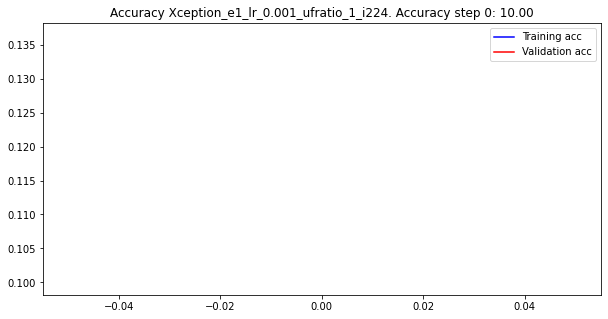

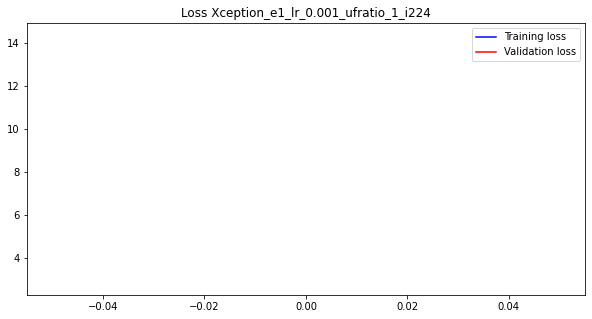

----------------------------------------
2/2 step training
Start training. Unfreeze: 1, LR: 0.0001
----------------------------------------
9/9 [==============================] - 19s 2s/step - loss: 2.5180 - accuracy: 0.1362 - val_loss: 11.4159 - val_accuracy: 0.1000

Epoch 00001: saving model to best_model.hdf5
2/2 [==============================] - 1s 255ms/step - loss: 11.4893 - accuracy: 0.1000
---------------------
Accuracy step 1: 10.00
---------------------


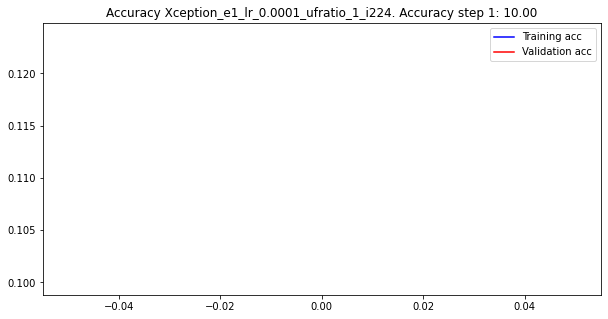

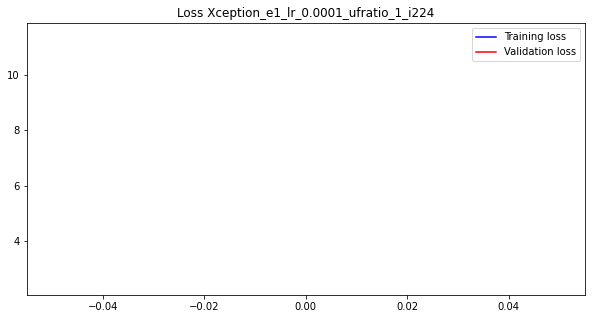

In [83]:
model = fine_tune_fit(work_model, input_shape, steps)

Увеличиваем разрешение изображений:


In [84]:
BATCH_SIZE = 32
IMG_SIZE = 300  # какого размера подаем изображения в сеть
input_shape = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

# first step = previous step for weights loading
steps = [(1e-4, 1, 10)]

if MOCK_DATA:
  steps = [(1e-4, 1, 1)]

In [85]:
(train_generator, val_generator,
 sub_generator, tta_generator) = build_generators()

Found 550 images belonging to 10 classes.
Found 90 images belonging to 10 classes.
Found 20 validated image filenames.
Found 20 validated image filenames.


----------------------------------------
1/1 step training
Start training. Unfreeze: 1, LR: 0.0001
----------------------------------------
18/18 [==============================] - 28s 1s/step - loss: 2.4282 - accuracy: 0.1242 - val_loss: 14.0827 - val_accuracy: 0.1000

Epoch 00001: saving model to best_model.hdf5
3/3 [==============================] - 2s 682ms/step - loss: 14.1156 - accuracy: 0.1000
---------------------
Accuracy step 0: 10.00
---------------------


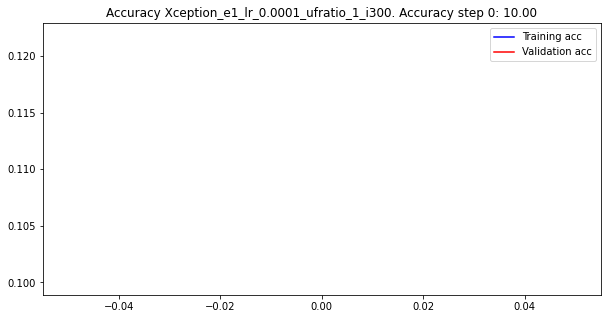

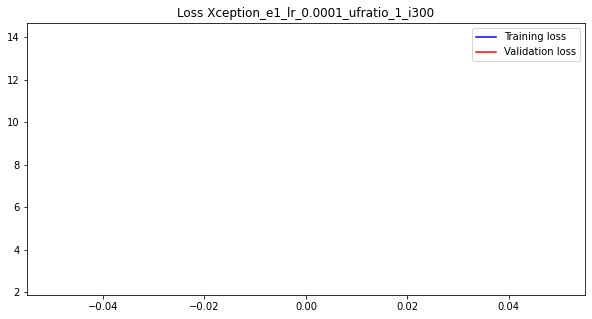

In [86]:
# load previous weights
model = fine_tune_fit(work_model, input_shape, steps,
                      weights='best_model.hdf5')


Делаем предсказания с использованием полученной модели

In [87]:
predict_xcept = predict_submit(model, name=model.name)

1/1 [==============================] - 1s 843ms/step


и использовании Test Time Augmentaition

In [88]:
predict_xcept_tta = predict_tta(model, tta_steps=10)

1/1 [==============================] - 0s 262ms/step


### EfficientNetB6

Обучение с использование fine-tunning и малого разрешения изображений:

In [89]:
work_model = models_efn_base

In [90]:
BATCH_SIZE = 16
IMG_SIZE = 224  # какого размера подаем изображения в сеть
input_shape = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

# list of steps (learning rate, unfreeze_ratio, epochs)
#  unfreeze_ratio: 0.0 - freeze, 1.0 - unfreeze base model
steps = [(1e-3, 0, 10),
        #  (1e-4, 0, 10),
        #  (1e-4, 0.25, 5),
         (1e-4, 0.5, 10),
         (1e-5, 1, 5)]

if MOCK_DATA:
  steps = [(1e-4, 1, 1)]

In [91]:
(train_generator, val_generator,
 sub_generator, tta_generator) = build_generators()

Found 550 images belonging to 10 classes.
Found 90 images belonging to 10 classes.
Found 20 validated image filenames.
Found 20 validated image filenames.


----------------------------------------
1/1 step training
Start training. Unfreeze: 1, LR: 0.0001
----------------------------------------
35/35 [==============================] - 50s 856ms/step - loss: 3.2118 - accuracy: 0.0847 - val_loss: 2.2377 - val_accuracy: 0.2111

Epoch 00001: saving model to best_model.hdf5
6/6 [==============================] - 2s 245ms/step - loss: 2.2262 - accuracy: 0.1556
---------------------
Accuracy step 0: 15.56
---------------------


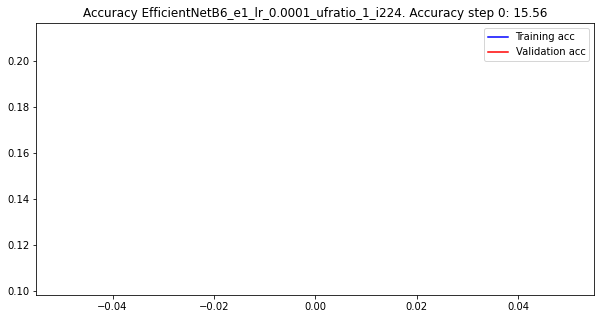

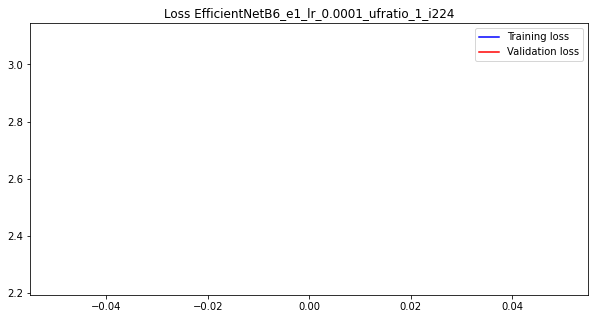

In [92]:
model = fine_tune_fit(work_model, input_shape, steps)

Увеличиваем разрешение изображений:


In [93]:
BATCH_SIZE = 4
IMG_SIZE = 300  # какого размера подаем изображения в сеть
input_shape = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

# first step = previous step for weights loading
steps = [(1e-4, 1, 10)]

if MOCK_DATA:
  steps = [(1e-4, 1, 1)]

In [94]:
(train_generator, val_generator,
 sub_generator, tta_generator) = build_generators()

Found 550 images belonging to 10 classes.
Found 90 images belonging to 10 classes.
Found 20 validated image filenames.
Found 20 validated image filenames.


----------------------------------------
1/1 step training
Start training. Unfreeze: 1, LR: 0.0001
----------------------------------------
138/138 [==============================] - 81s 434ms/step - loss: 2.3939 - accuracy: 0.2574 - val_loss: 1.9784 - val_accuracy: 0.3556

Epoch 00001: saving model to best_model.hdf5
23/23 [==============================] - 3s 117ms/step - loss: 1.9146 - accuracy: 0.4111
---------------------
Accuracy step 0: 41.11
---------------------


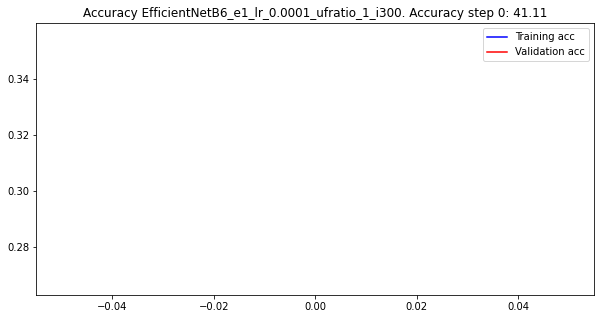

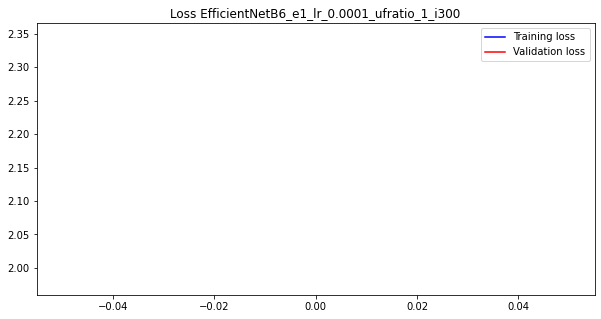

In [95]:
# load previous weights
model = fine_tune_fit(work_model, input_shape, steps,
                      weights='best_model.hdf5')


Делаем предсказания с использованием полученной модели

In [96]:
predict_efn = predict_submit(model, name=model.name)

5/5 [==============================] - 3s 103ms/step


и использовании Test Time Augmentaition

In [97]:
predict_efn_tta = predict_tta(model, tta_steps=10)

5/5 [==============================] - 0s 82ms/step


### Ensemble

Используем сумму полученных предсказаний

In [98]:
pred_sum = predict_xcept + predict_xcept_tta + predict_efn + predict_efn_tta
create_submission(pred_sum, name='ensemble')